<a href="https://colab.research.google.com/github/eddieguo-1128/honors/blob/main/Thesis_Code_Part2_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Thesis Code Part 2: BERT

In [1]:
# Import Packages
import pandas as pd
import numpy as np

In [2]:
# Connect to drive and acquire data from Part 1
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/My Drive/SP23/Honors Thesis/DATA H195B/data

/content/drive/My Drive/SP23/Honors Thesis/DATA H195B/data


In [6]:
reports_df = pd.read_csv('reports_df.csv',index_col=0)
pd.options.display.max_colwidth = 0
reports_df

,id,findings,impression,full-text,label
0,162,"Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses.",Normal chest,"Heart size normal. Lungs are clear. XXXX are normal. No pneumonia, effusions, edema, pneumothorax, adenopathy, nodules or masses. Normal chest",normal
1,1390,"The heart size and pulmonary vascularity appear within normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. VP shunt tubing is identified. The bony structures, as visualized, appear unremarkable.",No evidence of active disease.,"The heart size and pulmonary vascularity appear within normal limits. Lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. VP shunt tubing is identified. The bony structures, as visualized, appear unremarkable. No evidence of active disease.",abnormal
2,604,The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. PICC line is in XXXX. The tip is in the upper right atrium.,1. No evidence of active disease.,The heart size and pulmonary vascularity appear within normal limits. The lungs are free of focal airspace disease. No pleural effusion or pneumothorax is seen. PICC line is in XXXX. The tip is in the upper right atrium. 1. No evidence of active disease.,abnormal
3,2699,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion. Multiple punctate round XXXX XXXX over the abdomen on the lateral view. These may reside within, or outside of the patient.",No acute cardiopulmonary disease.,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion. Multiple punctate round XXXX XXXX over the abdomen on the lateral view. These may reside within, or outside of the patient. No acute cardiopulmonary disease.",normal
4,2841,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.",No acute cardiopulmonary disease.,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion. No acute cardiopulmonary disease.",normal
...,...,...,...,...,...
3950,2694,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion.",No acute cardiopulmonary disease.,"The heart is normal in size and contour. The lungs are clear, without evidence of infiltrate. There is no pneumothorax or effusion. No acute cardiopulmonary disease.",normal
3951,2858,Heart size normal. Tortuous aorta. Sequela primary granulomatous disease. Lungs clear. Minimal spurring in the thoracic spine.,No acute cardiopulmonary finding.,Heart size normal. Tortuous aorta. Sequela primary granulomatous disease. Lungs clear. Minimal spurring in the thoracic spine. No acute cardiopulmonary finding.,abnormal
3952,2680,The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal.,No acute pulmonary disease.,The lungs are clear. There is no pleural effusion or pneumothorax. The heart and mediastinum are normal. The skeletal structures are normal. No acute pulmonary disease.,normal
3953,85,There are scattered calcified granulomas. No focal infiltrate. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits. There are degenerative changes of the spine.,No evidence of active disease.,There are scattered calcified granulomas. No focal infiltrate. No pleural effusion or pneumothorax. Heart size and mediastinal contour are within normal limits. There are degenerative changes of the spine. No evidence of active disease.,abnormal


## BERT

In [7]:
!pip install transformers
#!pip install pytorch-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 72.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.4/176.4 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 62.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.5/135.5 KB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 105.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 KB 11.7 MB/s eta 0:00:00
  Created wheel for sacremoses: filen

In [8]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.utils import pad_sequences
from transformers import AutoTokenizer, AutoModel
from pytorch_transformers import AdamW, WarmupLinearSchedule
from tqdm import tqdm, trange
import io
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F

In [9]:
import tensorflow as tf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [10]:
def prepare_data(df):
  # Create sentence and label lists
  sentences = df['full-text'].values

  # We need to add special tokens at the beginning and end of each sentence for BERT to work properly
  sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
  labels = df.label.values
  labels = np.array([0 if x=="normal" else 1 for x in labels])

  tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
  tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]

  # Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
  # In the original paper, the authors used a length of 512.
  MAX_LEN = 512

  # Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
  input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

  # Pad our input tokens
  input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

  # Create attention masks
  attention_masks = []
  
  # Create a mask of 1s for each token followed by 0s for padding
  for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)
  
  return input_ids, attention_masks, labels

In [11]:
from sklearn.model_selection import train_test_split

# fix seed for reproducibility
np.random.seed(2023)

train, test = train_test_split(reports_df, test_size = 0.2, shuffle=True)
train, validation = train_test_split(train, test_size = 0.1, shuffle=True)

In [12]:
train_inputs, train_masks, train_labels = prepare_data(train)
validation_inputs, validation_masks, validation_labels = prepare_data(validation)
test_inputs, test_masks, test_labels = prepare_data(test)

In [13]:
# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [14]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 32

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [15]:
class BERTClassifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = AutoModel.from_pretrained("bert-base-uncased")
    self.linear1 = nn.Linear(768, 32)
    self.classifier = nn.Linear(32, 2)
    self.dropout = nn.Dropout(p=0.1)

  def forward(self, input_ids, token_type_ids, attention_mask):
    output = self.model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)
    output = output[1]
    # output = torch.concat((output, parties), dim=1)
    output = self.dropout(output)
    output = self.linear1(output)
    output = self.dropout(output)
    output = F.relu(output)
    output = self.classifier(output)
    return output

In [16]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top. 

model = BERTClassifier()
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

In [17]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [18]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=100, t_total=1000) #0.1 warmup total

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    loss = F.cross_entropy(outputs, b_labels)
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/pytorch_transformers/optimization.py:166: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1420.)
  exp_avg.mul_(beta1).add_(1.0 - beta1, grad)


Train loss: 0.5456483489676808


Epoch:  25%|██▌       | 1/4 [01:00<03:00, 60.28s/it]

Validation Accuracy: 0.940301724137931
Train loss: 0.19697611766417375


Epoch:  50%|█████     | 2/4 [01:58<01:58, 59.11s/it]

Validation Accuracy: 0.971875
Train loss: 0.10957593393376035


Epoch:  75%|███████▌  | 3/4 [02:57<00:58, 58.80s/it]

Validation Accuracy: 0.975
Train loss: 0.07147063199807419


Epoch: 100%|██████████| 4/4 [03:55<00:00, 58.79s/it]

Validation Accuracy: 0.9875


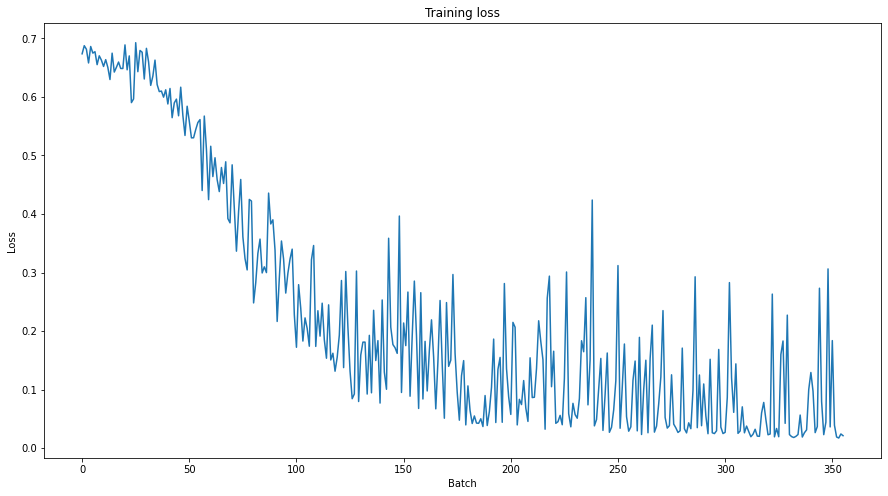

In [21]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [23]:
torch.save(model.state_dict(), 'fine-tuned-bert.pth')

In [24]:
# Prediction on test set
prediction_inputs = torch.tensor(test_inputs)
prediction_masks = torch.tensor(test_masks)
prediction_labels = torch.tensor(test_labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

In [25]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [26]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [27]:
matthews_corrcoef(flat_true_labels, flat_predictions)

0.9253952821249513